In [1]:
# compute the adsorption correction tree/ surface Pt111 thermo covariance matrix

In [53]:
import os
import re
import sys
import glob
import pickle
import copy
import pandas as pd
import numpy as np
import rmgpy.chemkin
import rmgpy.tools.uncertainty
import rmgpy.kinetics.uncertainties

import rmgpy.tools.canteramodel
import random

import rmgpy.kinetics
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# --------------- CAUTION!!! Databases here must match the ones used to generate the mechanism
thermo_libs = [
    'surfaceThermoPt111',
    'primaryThermoLibrary',
    'thermo_DFT_CCSDTF12_BAC',
    'DFT_QCI_thermo'
]
kinetic_libs = [
    'Surface/CPOX_Pt/Deutschmann2006_adjusted',
    'BurkeH2O2inArHe'
]

kinetics_families = [
    'default',
    'Surface_Adsorption_Single',
    'Surface_Adsorption_vdW',
    'Surface_Adsorption_Dissociative',
    'Surface_Dissociation',
    'Surface_Abstraction',
    'Surface_Dissociation_Double_vdW',
    'Surface_Dissociation_vdW',
    'Surface_Abstraction_vdW',
    'Surface_Dissociation_Beta',
    'Surface_Adsorption_Bidentate',
    'Surface_Bidentate_Dissociation',
    'Surface_Monodentate_to_Bidentate',
    'Surface_Dissociation_to_Bidentate', 
    'Surface_vdW_to_Bidentate',
    'Surface_Adsorption_Dissociative_Double',
    'Surface_Abstraction_Beta',
    # 'Surface_Abstraction_Beta_double_vdW',
    'Surface_Dissociation_Double',
    'Surface_Dissociation_Beta_vdW',
    'Surface_Abstraction_Beta_vdW',
    'Surface_Abstraction_Single_vdW',
]


In [5]:
database = rmgpy.data.rmg.RMGDatabase()

database.load(
    path = rmgpy.settings['database.directory'],
    thermo_libraries = thermo_libs,
    transport_libraries = [],
    reaction_libraries = [],
    seed_mechanisms = [],
    kinetics_families = [],
    kinetics_depositories = ['training'],
    #frequenciesLibraries = self.statmechLibraries,
    depository = False,
)
for family in database.kinetics.families:
    if not database.kinetics.families[family].auto_generated:
        database.kinetics.families[family].add_rules_from_training(thermo_database=database.thermo)
        database.kinetics.families[family].fill_rules_by_averaging_up(verbose=True)


ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([60.2599,68.0494,74.7775,80.9311,90.8846,97.4337,105.393],'J/(mol*K)'), H298=(-477.191,'kJ/mol'), S298=(269.551,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(103.931,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-(Cds-Cd)(Cds-Cd)) + group(O2s-(Cds-O2d)H) + group(Cds-OdOsOs) + group(Li-OCOdO) + radical(OC=OOJ)""").
The thermo for this species is probably wrong! Setting CpInf = Cphigh for Entropy calculationat T = 2000.0 K...
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([60.2599,68.0494,74.7775,80.9311,90.8846,97.4337,105.393],'J/(mol*K)'), H298=(-477.191,'kJ/mol'), S298=(269.551,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(103.931,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-(Cds-Cd)(Cds-Cd)) + group(O2s-(Cds-O2d)H) + group(Cds-OdOsOs) + group(Li-OCOdO) + radical(OC=OOJ)""").
The thermo for this species is probably wrong! Setting CpInf = Cphigh for En

In [131]:
database.thermo.libraries['surfaceThermoPt111'].entries

OrderedDict([('vacant', <Entry index=1 label="vacant">),
             ('XH', <Entry index=2 label="XH">),
             ('H2X', <Entry index=3 label="H2X">),
             ('H2OX', <Entry index=4 label="H2OX">),
             ('XOH', <Entry index=5 label="XOH">),
             ('HOOHX', <Entry index=6 label="HOOHX">),
             ('XOXO', <Entry index=7 label="XOXO">),
             ('XOOH', <Entry index=8 label="XOOH">),
             ('XO', <Entry index=9 label="XO">),
             ('XONH2', <Entry index=10 label="XONH2">),
             ('XOCH3', <Entry index=11 label="XOCH3">),
             ('NH3X', <Entry index=12 label="NH3X">),
             ('XNH2', <Entry index=13 label="XNH2">),
             ('XNH', <Entry index=14 label="XNH">),
             ('XN', <Entry index=15 label="XN">),
             ('H2NOHX', <Entry index=16 label="H2NOHX">),
             ('HNOX', <Entry index=17 label="HNOX">),
             ('XNHOH', <Entry index=18 label="XNHOH">),
             ('XNO', <Entry index=19 la

In [13]:
# get the names of all the adsorption correction groups
db_ads_group_items = [database.thermo.groups['adsorptionPt111'].entries[key].item for key in database.thermo.groups['adsorptionPt111'].entries]


In [127]:
database.thermo.groups['adsorptionPt111'].entries['N=*O-*'].data

ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([1.99,2.43,2.68,2.82,2.96,3,3.01],'cal/(mol*K)'), H298=(-42.57,'kcal/mol'), S298=(-35.43,'cal/(mol*K)'))

0

'R*'

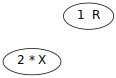

1

'(OR2)*'

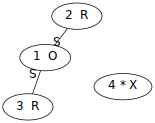

2

'O-*R'

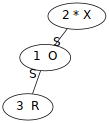

3

'(OROR)*'

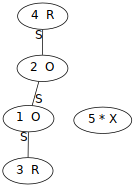

4

'O*O*'

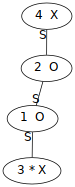

5

'O-*OR'

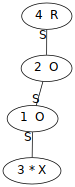

6

'O=*'

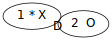

7

'O-*NR2'

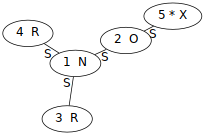

8

'O-*CR3'

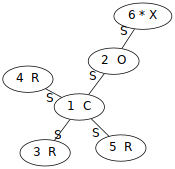

9

'(NR3)*'

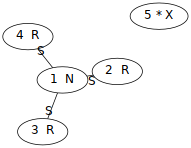

10

'N-*R2'

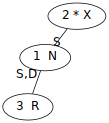

11

'N=*R'

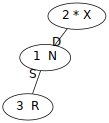

12

'N#*'

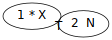

13

'(NR2OR)*'

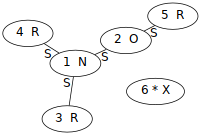

14

'(NRO)*'

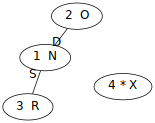

15

'N-*ROR'

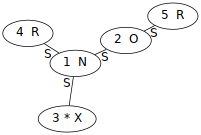

16

'N-*O'

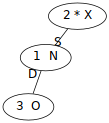

17

'N=*O-*'

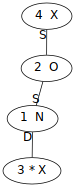

18

'N=*OR'

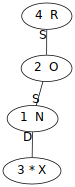

19

'(NR2NR2)*'

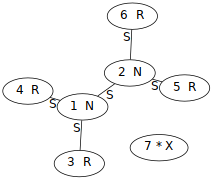

20

'(NRNR)*'

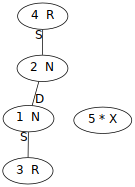

21

'N-*RNR2'

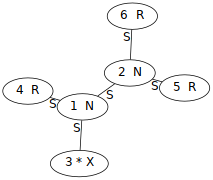

22

'N-*NR'

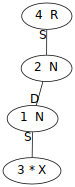

23

'N=*NR2'

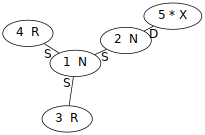

24

'N-*RN-*R'

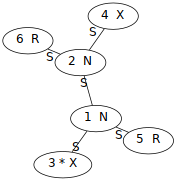

25

'N-*RCR3'

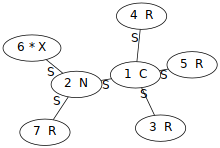

26

'N-*CR2'

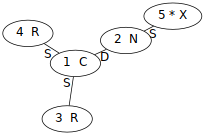

27

'N=*CR3'

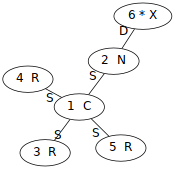

28

'Cq*'

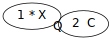

29

'C-*C-*'

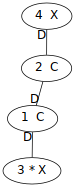

30

'C=*(=R)'

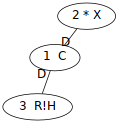

31

'C#*CR3'

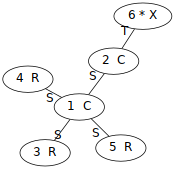

32

'C#*R'

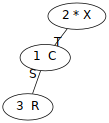

33

'C=*RC=*R'

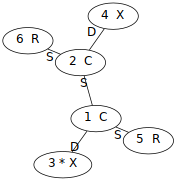

34

'C=*R2'

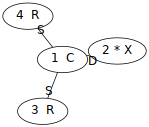

35

'C-*R2C-*R2'

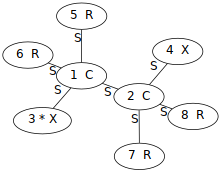

36

'C-*R3'

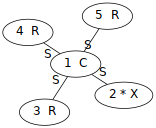

37

'(CR3CR3)*'

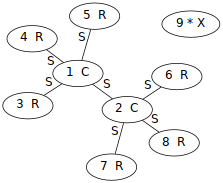

38

'(CR4)*'

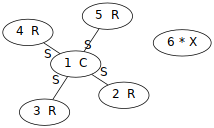

39

'C=*N-*'

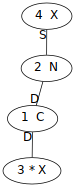

40

'C=*(=NR)'

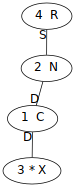

41

'C#*NR2'

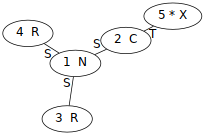

42

'C#*OR'

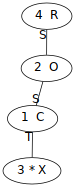

43

'C-*R2C=*R'

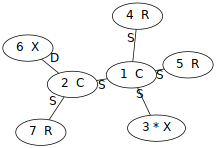

44

'C-*R2CR3'

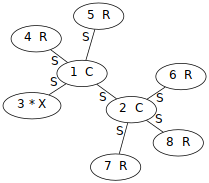

45

'(CR2NR)*'

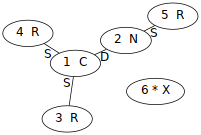

46

'C-*R2NR2'

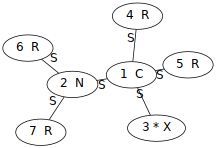

47

'(CR2O)*'

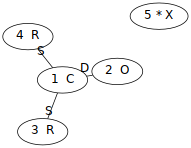

48

'C-*R2OR'

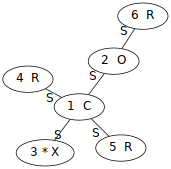

49

'(CR3NR2)*'

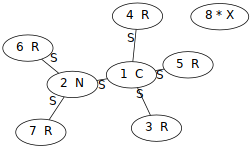

50

'(CR3OR)*'

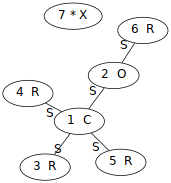

51

'C-*RC=*'

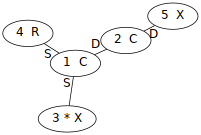

52

'C-*RCR2'

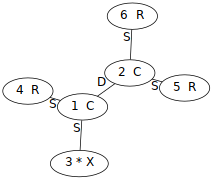

53

'C=*RCR3'

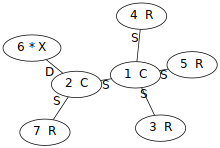

54

'(CRN)*'

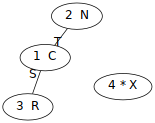

55

'C=*RN=*'

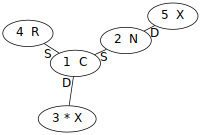

56

'C-*RNR'

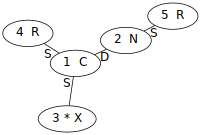

57

'C=*RN-*R'

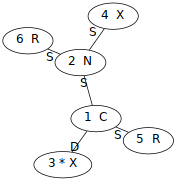

58

'C=*RNR2'

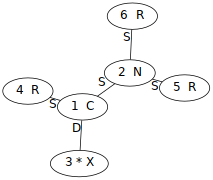

59

'C-*RO'

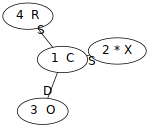

60

'C=*RO-*'

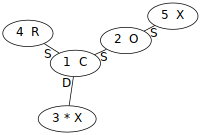

61

'C=*ROR'

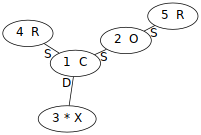

62

'C*'

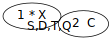

63

'N*'

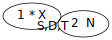

64

'O*'

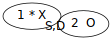

65

'R*single-chemisorbed'

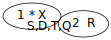

66

'C*C*'

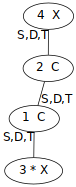

67

'C*N*'

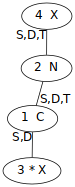

68

'C*O*'

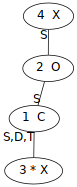

69

'N*N*'

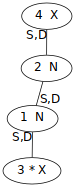

70

'R*bidentate'

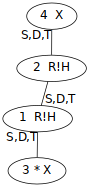

71

'R*vdW'

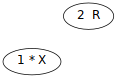

72

'N*O*'

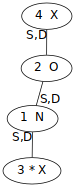

73

'(CR3)*'

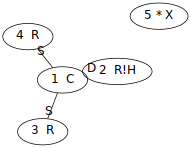

74

'(CR2)*'

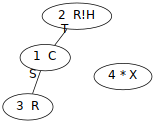

75

'(N=[O,N]R)*'

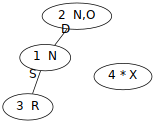

76

'N-*RN=*'

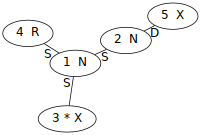

77

'(CRCR)*'

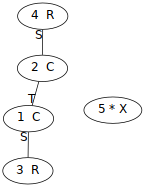

78

'C-*R2N=*'

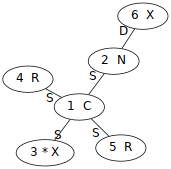

79

'C-*R2N-*R'

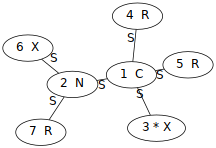

80

'C=*(=C)'

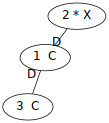

81

'C-*R2O-*'

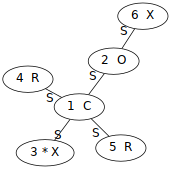

82

'(CR2CR)*'

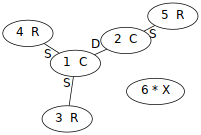

83

'C=*RC-*R'

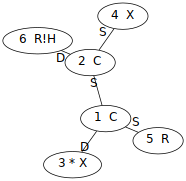

84

'C#*C-*R'

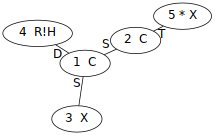

85

'C#*C-*R2'

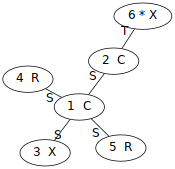

86

'C-*R2C-*R'

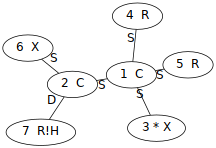

87

'C-*RC-*R'

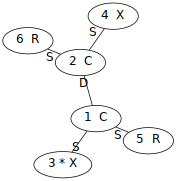

88

'C#*C=*R'

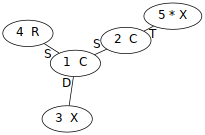

89

'C=*=R-C-*R2'

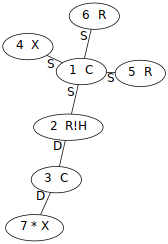

90

'R2C-*-R-C-*R2'

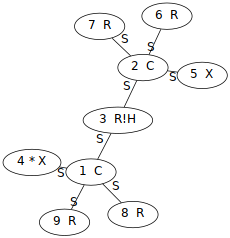

91

'RC=*-R=C-*R'

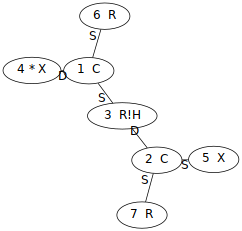

92

'RC-*=R-C-*R2'

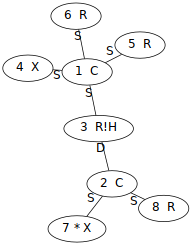

93

'RC=*-R-C-*R2'

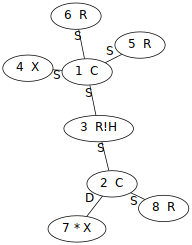

94

'RC-*=R=C-*R'

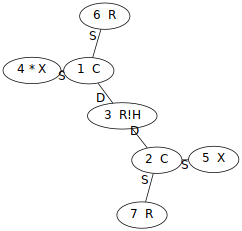

95

'RC-*=R=C=*'

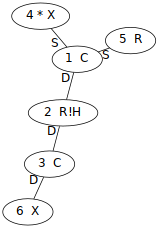

96

'O-*-C-O-*'

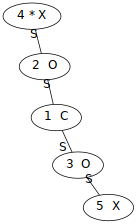

97

'RC-*=R-O-*'

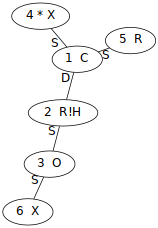

98

'C-*R2'

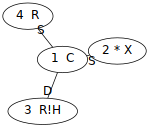

99

'C=*RCR2'

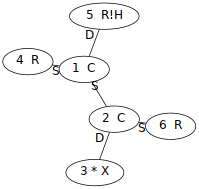

100

'C#*CR2'

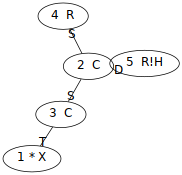

101

'O-*CR2'

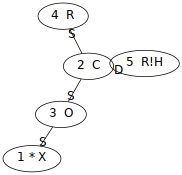

102

'C*RC*'

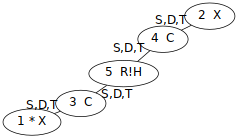

103

'R*bridged-bidentate'

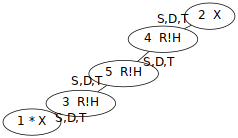

104

'C*RO*'

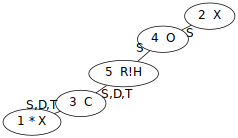

105

'O*RO*'

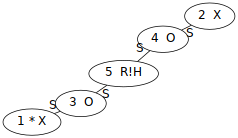

106

'C#*-R-C-*R2'

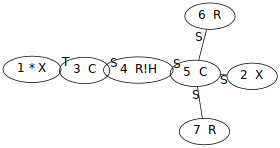

107

'C#*-R=C-*R'

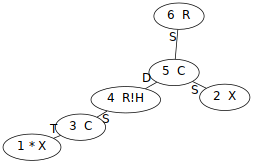

108

'C#*-R-C#*'

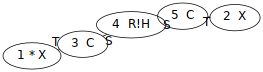

109

'RC=*-R-C=*R'

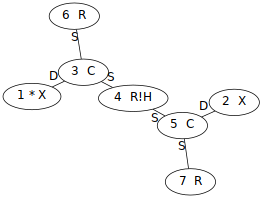

110

'C#*-R-C=*R'

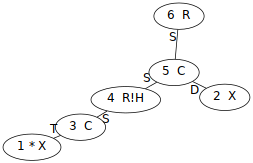

In [125]:
for i, key in enumerate(database.thermo.groups['adsorptionPt111'].entries):
    display(i, key, database.thermo.groups['adsorptionPt111'].entries[key].item)
    
    

In [81]:
len(db_ads_group_items)

111

In [20]:
def get_name_from_path(path):
    search_pattern = r'beef-ensembles/(.+)_bee.txt'
    m1 = re.search(search_pattern, path)
    if m1 is not None:
        return m1[1]

In [190]:
# load each of the species ensembles from files
bee_files = sorted(glob.glob('/home/moon/thermo_kinetics_scripts/beef-uq/thermo/beef-ensembles/*_bee.txt'))





In [24]:
# load their thermo library
thermo_lib = '/home/moon/thermo_kinetics_scripts/beef-uq/thermo/lib'
thermo_database = rmgpy.data.thermo.ThermoDatabase()
thermo_database.load_libraries(thermo_lib)

items = [thermo_database.libraries['surfaceThermoPt111'].entries[e].item for e in thermo_database.libraries['surfaceThermoPt111'].entries]
labels = [thermo_database.libraries['surfaceThermoPt111'].entries[e].label for e in thermo_database.libraries['surfaceThermoPt111'].entries]

In [191]:
# get the adjacency list for each species
molecules = []
species_names = []
for i in range(len(bee_files)):
    sp_name = get_name_from_path(bee_files[i])
    species_names.append(sp_name)
    assert sp_name is not None
    try:
        entry_index = labels.index(sp_name)
        molecules.append(items[entry_index])
#         display(items[entry_index])
    except ValueError:
        print(f'No {i} {sp_name}')


In [192]:
# Save a pickle file with the order of species
molecule_ads = [item.to_adjacency_list() for item in molecules]
with open('beef_species_list.pickle', 'wb') as f:
    pickle.dump(molecule_ads, f)

In [ ]:
# save the species ensemble matrix

In [34]:
# Save a pickle file with the order for the cov matrix
all_items = db_ads_group_items + molecules
my_item_list = [item.to_adjacency_list() for item in all_items]

with open('my_ads_corr_list.pickle', 'wb') as f:
    pickle.dump(my_item_list, f)


In [35]:
with open('my_ads_corr_list.pickle', 'rb') as f:
    data = pickle.load(f)

In [103]:
reconstructed_items = []
for i in range(len(data)):
    if i < len(db_ads_group_items):
        mol = rmgpy.molecule.Group().from_adjacency_list(data[i])
    else:
        mol = rmgpy.molecule.Molecule().from_adjacency_list(data[i])
        
    reconstructed_items.append(mol)
assert len(data) == len(reconstructed_items)

n_groups = np.sum([isinstance(mol, rmgpy.molecule.Group) for mol in reconstructed_items])
n_mols = np.sum([isinstance(mol, rmgpy.molecule.Molecule) for mol in reconstructed_items])
assert n_groups == len(db_ads_group_items)

In [193]:
M = len(bee_files)
assert M == n_mols
N = 2000
Hf = np.zeros((M, N))
delta_Hf = np.zeros((M, N))

for i in range(M):  # in kJ/mol
    df = pd.read_csv(bee_files[i], sep='\t')
    Hf[i, :] = df['Hf'].values
    delta_Hf[i, :] = df[df.columns[1]].values

In [195]:
np.save('beef_species_ensembles.npy', delta_Hf.shape)

In [161]:
# spot check the names of files
bee_files[-1]

'/home/moon/thermo_kinetics_scripts/beef-uq/thermo/beef-ensembles/XO_bee.txt'

In [162]:
reconstructed_items[n_groups + 181]

In [163]:
len(bee_files)

182

In [148]:
# need to construct the (#nodes + #species) x 2000 matrix that I can then call cov on
ads_ensembles = np.zeros((len(all_items), N))

for i in range(n_groups):
    # get all molecules that match that node
    # (assuming they were all used in the training, but this is not necessarily true) 
#     display(reconstructed_items[i])
    training_mols = 0
    for j in range(n_mols):
        if reconstructed_items[n_groups + j].is_subgraph_isomorphic(reconstructed_items[i], generate_initial_map=True):
#             print(reconstructed_items[n_groups + j])
            ads_ensembles[i, :] += delta_Hf[j, :]
            training_mols += 1
    
    if training_mols > 0:
        ads_ensembles[i, :] /= training_mols
    else:
        ads_ensembles[i, :] = np.nan  # no data

# also fill in the individual species        
for i in range(n_mols):
    ads_ensembles[n_groups + i, :] += delta_Hf[i, :]


In [ ]:
uncertainty.th

In [172]:
covX = np.cov(ads_ensembles) / 4.18 / 4.18

In [189]:
np.save('ads_correction_covarance_kcal_mol2.npy', covX)

In [173]:
covX[17,17]

nan

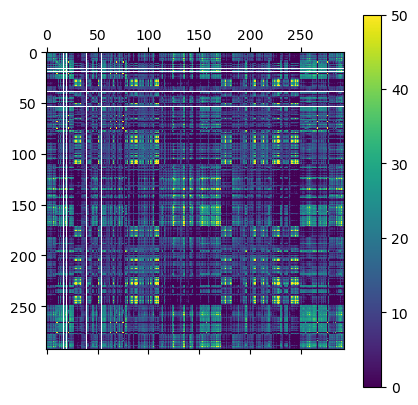

In [175]:
plt.matshow(covX)
plt.colorbar()
plt.clim([0, 50])

In [177]:
np.nanpercentile(covX, 95)

27.588626000502135

In [178]:
np.nanmax(covX)

2829.391330625703

In [179]:
np.float_power(2829, 0.5)

53.1883445878888

(array([285.,   0.,   2.,   0.,   0.,   0.,   0.,   0.,   0.,   2.]),
 array([1.27708648e+00, 2.84088511e+02, 5.66899935e+02, 8.49711360e+02,
        1.13252278e+03, 1.41533421e+03, 1.69814563e+03, 1.98095706e+03,
        2.26376848e+03, 2.54657991e+03, 2.82939133e+03]),
 <BarContainer object of 10 artists>)

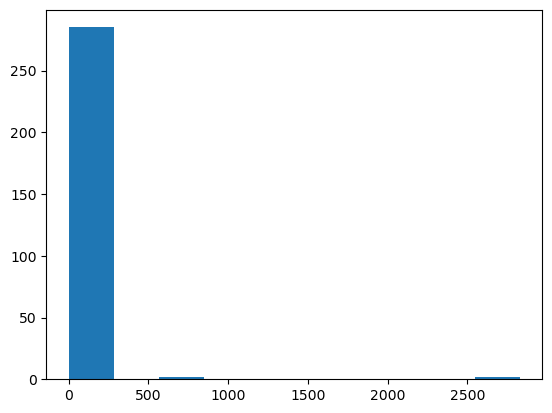

In [181]:
plt.hist(np.diagonal(covX))

In [183]:
for i in range(covX.shape[0]):
    if covX[i, i] > 500:
        print(i)

22
76
266
276


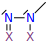

In [184]:
reconstructed_items[276]

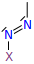

In [186]:
reconstructed_items[266]

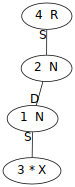

In [187]:
reconstructed_items[22]

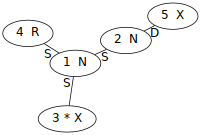

In [188]:
reconstructed_items[76]